In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchaudio
import PIL
from torch.functional import F
import IPython
from IPython.display import Audio, display

Decargando nuestra data: Speech Commands

In [4]:
sc_train_ds = torchaudio.datasets.SPEECHCOMMANDS("./",download=True,subset="training")
sc_test_ds = torchaudio.datasets.SPEECHCOMMANDS("./",download=True,subset="testing")

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

In [5]:
speech_labels = ["Backward",
"Bed",
"Bird",
"Cat",
"Dog",
"Down",
"Eight",
"Five",
"Follow",
"Forward",
"Four",
"Go",
"Happy",
"House",
"Learn",
"Left",
"Marvin",
"Nine",
"No",
"Off",
"On",
"One",
"Right",
"Seven",
"Sheila",
"Six",
"Stop",
"Three",
"Tree",
"Two",
"Up",
"Visual",
"Wow",
"Yes",
"Zero"]
speech_dict = {k.lower():v for v,k in enumerate(speech_labels)}

In [6]:
len(speech_labels)

35

In [23]:
sc_train_ds[900]

(tensor([[-0.0002, -0.0006,  0.0002,  ..., -0.0061, -0.0107, -0.0102]]),
 16000,
 'backward',
 'af6fbbf5',
 2)

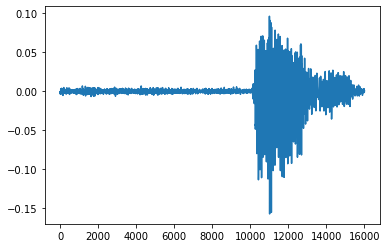

In [15]:
plt.plot(sc_train_ds[2000][0].numpy()[0])

In [16]:
display(Audio(data=sc_train_ds[2000][0].numpy()[0],rate=16000))

# Usemos Convolucion 1D para speech recognition

Preparando el Dataset

In [17]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self,raw_data):
    self.raw_data = raw_data
    self.resampling = torchaudio.transforms.Resample(new_freq=8000)
  
  def __len__(self):
    return len(self.raw_data)
  
  def __getitem__(self,idx):
    x, _, y, _, _ = self.raw_data[idx]
    C, L = x.shape
    if L!=16000:
      x = F.pad(x,(0,16000 - L),mode="constant",value=0.0)
    return self.resampling(x), speech_dict[y]

In [18]:
train_ds = MyDataset(sc_train_ds)
test_ds = MyDataset(sc_test_ds)

In [19]:
x, l = next(iter(train_ds))

In [20]:
x.shape

torch.Size([1, 8000])

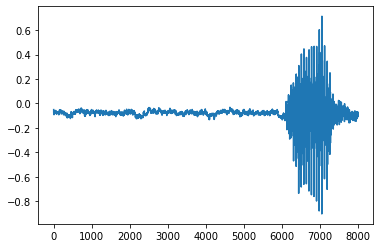

In [21]:
plt.plot(x.numpy().reshape(-1))

Creamos nuestro DataLoader

In [24]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128,shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=128,shuffle=True)

Definamos nuestro modelo

In [25]:
for x,y in test_dl:
  print(x.shape)
  print(y)
  break

torch.Size([128, 1, 8000])
tensor([17,  6,  0,  9,  8, 16,  2,  0,  7, 10, 17, 27, 20,  9,  2, 26, 18, 17,
        30,  6, 11, 15, 19, 20, 15, 26, 23, 19, 32, 16, 30, 15,  5, 11, 12, 19,
         5,  4, 31, 33, 16, 33,  9, 33, 34, 20, 31,  1, 26,  3, 23, 13,  9, 19,
        33, 27, 20, 20,  5, 17, 26, 11, 20, 15, 25, 34,  1, 15,  7, 31, 15, 26,
        19, 17, 19, 16, 27, 26, 15,  6, 17, 17,  7, 10, 11, 11, 19,  7, 10, 12,
        17, 29, 21, 29, 27, 34,  2,  6, 24, 25, 10,  6, 23, 17, 14, 27, 29,  5,
        12, 17,  7, 27, 15,  3, 30, 20, 34, 23,  2, 22,  6, 27, 15, 12, 15,  6,
        29,  6])


In [26]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [27]:
model = nn.Sequential(
    nn.Conv1d(1,32,100,stride=40,bias=False),
    nn.BatchNorm1d(32),
    nn.ReLU(inplace=True),
    nn.Conv1d(32,64,3,bias=False),
    nn.BatchNorm1d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(4),
    nn.Conv1d(64,64,3,bias=False),
    nn.BatchNorm1d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(4),
    nn.Flatten(),
    nn.Linear(64*11,35)
).to(dev)

Entrenando nuestro modelo

In [28]:
def evaluate(model, loader, crit):
  model.eval()
  total = 0
  corrects = 0
  avg_loss = 0
  for x, y in loader:
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    loss = crit(o,y)
    avg_loss += loss.item()
    corrects += torch.sum(torch.argmax(o,axis=1) == y).item()
    total += len(y)
  acc = 100* corrects / total
  avg_loss /= len(loader)  
  return avg_loss, acc

def train_one_epoch(model, train_loader, crit, optim):
  model.train()
  total = 0
  corrects = 0
  avg_loss = 0
  for x, y in train_loader:
    optim.zero_grad()
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    loss = crit(o,y)
    avg_loss += loss.item()
    loss.backward()
    optim.step()
    corrects += torch.sum(torch.argmax(o,axis=1) == y).item()
    total += len(y)
  acc = 100 * corrects / total
  avg_loss /= len(train_loader)
  return avg_loss, acc

def train(model, train_loader, test_loader, crit, optim, epochs = 20):
  for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader,crit, optim)
    test_loss, test_acc = evaluate(model, test_loader, crit)
    print(f"epoch: {epoch}, train loss: {train_loss}, train acc: {train_acc}%, test loss: {test_loss}, test acc: {test_acc}%")

In [29]:
crit = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(),lr=0.1)
train(model,train_dl, test_dl, crit,optim,epochs=10)

KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(),"speech_commnad_model_conv1d.ckpt")

In [30]:
model.load_state_dict(torch.load("speech_commnad_model_conv1d.ckpt"))
model.eval()

Sequential(
  (0): Conv1d(1, 32, kernel_size=(100,), stride=(40,), bias=False)
  (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), bias=False)
  (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (7): Conv1d(64, 64, kernel_size=(3,), stride=(1,), bias=False)
  (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=704, out_features=35, bias=True)
)

In [33]:
idx = 20100
audio_ = Audio(data=sc_train_ds[idx][0][0].numpy(),rate=16000)
pred = torch.argmax(model(train_ds[idx][0].reshape(1,1,8000).to(dev)).cpu(),axis=1)[0].item()
print(speech_labels[pred])
display(audio_)

Four


# Usemos Espectrogramas y Convolucion 2D para speech recognition

# Transformada de Fourier

In [35]:
t0=0
tf=5
N = 100

sample_freq = N / (tf - t0)
sample_w = 2 * torch.pi * sample_freq
dummy_x = torch.linspace(t0,tf,N)
w1, w2, w3 = 2, 10 , 40
dummy_y = 2*torch.sin(w1 * dummy_x) + 2*torch.cos(w2 *dummy_x) +2*torch.sin(w3 * dummy_x)

In [36]:
dummy_fft = torch.fft.fft(dummy_y)

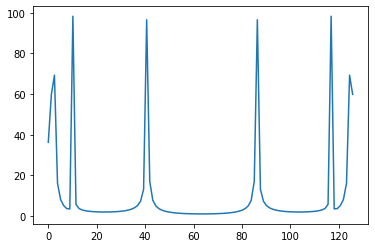

In [37]:
plt.plot(torch.linspace(0,sample_w,100), dummy_fft.abs())

In [39]:
sample = sc_test_ds[10][0][0]

In [40]:
sample_fft = torch.fft.fft(sample).abs()

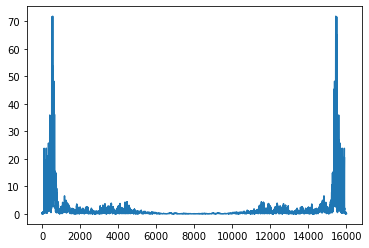

In [41]:
plt.plot(sample_fft)

# Espectrograma

In [42]:
fft_per_window = []
for i in range(16000 // 80):
  tmp = sample[i*80: 80*i + 160]
  fft_per_window.append(torch.fft.fft(tmp).abs().numpy()[:80])
fft_per_window = np.array(fft_per_window).T

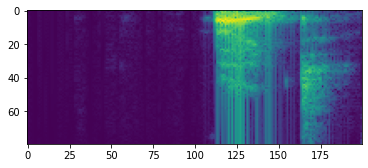

In [43]:
plt.imshow(np.log(fft_per_window + 1e-3))

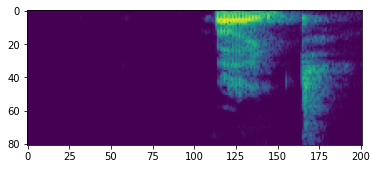

In [44]:
plt.imshow(np.log(torchaudio.transforms.Spectrogram(n_fft=160)(sample).numpy()+1e-5))

Backward
torch.Size([1, 8000])
-11.512923
Backward
torch.Size([1, 8000])
-11.512925


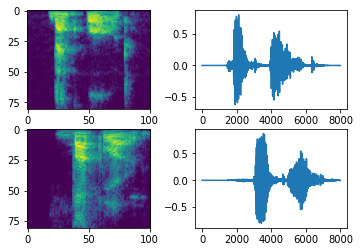

In [45]:
count = 0
idx = 0
fig, axs = plt.subplots(2,2)
for x, l in test_ds:
  if l ==idx :
    print(speech_labels[l])
    print(x.shape)
    N, l = x.shape
    y = torchaudio.transforms.Spectrogram(n_fft=160)(x)
    I=np.log(y[0].numpy() + 1e-5)
    print(np.min(I))
    axs[count,0].imshow(I)
    axs[count,1].plot(x[0].numpy())
    count += 1
    if count == 2:
      break

Definamos nuestro dataset

In [46]:
class MySpectrogramDataset(torch.utils.data.Dataset):
  def __init__(self,raw_data):
    self.raw_data = raw_data
    self.resampling = torchaudio.transforms.Resample(new_freq=8000)
    self.spectrogram = torchaudio.transforms.Spectrogram(n_fft=160)
  
  def __len__(self):
    return len(self.raw_data)
  
  def __getitem__(self,idx):
    x, _, y, _, _ = self.raw_data[idx]
    C, L = x.shape
    if L!=16000:
      x = F.pad(x,(0,16000 - L),mode="constant",value=0.0)
    return torch.log(self.spectrogram(self.resampling(x)) + 1e-5), speech_dict[y]

In [47]:
train_ds = MySpectrogramDataset(sc_train_ds)
test_ds = MySpectrogramDataset(sc_test_ds)

Preparemos nuestro dataloader

In [48]:
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=128,shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=128,shuffle=True)

Definamos nuestro modelo

In [49]:
model = nn.Sequential(
  nn.Conv2d(1,16,7,bias=False),
  nn.BatchNorm2d(16),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Conv2d(16,32,3,bias=False),
  nn.BatchNorm2d(32),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Conv2d(32,64,3,bias=False),
  nn.BatchNorm2d(64),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Conv2d(64,64,3,bias=False),
  nn.BatchNorm2d(64),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Flatten(),
  nn.Linear(64*8,35)
).to(dev)

Entrenemos nuestro modelo

In [ ]:
crit = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(),lr=0.1)
train(model,train_dl, test_dl, crit,optim,epochs=10)

epoch: 0, train loss: 0.951274046649086, train acc: 72.58583501290619%, test loss: 0.7533240823378397, test acc: 78.35529304861427%
epoch: 1, train loss: 0.4384548713637131, train acc: 87.20224414506795%, test loss: 0.5781730974829474, test acc: 83.88914129940936%
epoch: 2, train loss: 0.34794845134033897, train acc: 89.72690734651061%, test loss: 0.3956965577171379, test acc: 88.75056792367106%
epoch: 3, train loss: 0.29899877323143936, train acc: 91.04345673773912%, test loss: 0.3693034633950785, test acc: 89.33212176283507%
epoch: 4, train loss: 0.26458484750451045, train acc: 92.0464858621218%, test loss: 0.3489479671048304, test acc: 89.88641526578827%
epoch: 5, train loss: 0.23905365156528832, train acc: 92.85150218639133%, test loss: 0.3722540062072492, test acc: 89.41390277146752%
epoch: 6, train loss: 0.21450624391341758, train acc: 93.52922456773099%, test loss: 0.3936675923908952, test acc: 89.22308041799182%
epoch: 7, train loss: 0.19756278496756757, train acc: 94.020720625

In [ ]:
torch.save(model.state_dict(),"speech_command_model_spectrogram.ckpt")

In [50]:
model.load_state_dict(torch.load("speech_command_model_spectrogram.ckpt"))
model.eval()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), bias=False)
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU(inplace=True)
  (15): Ma

In [53]:
idx = 5000
audio_ = Audio(data=sc_test_ds[idx][0][0].numpy(),rate=16000)
pred = torch.argmax(model(test_ds[idx][0].reshape(1,1,81,101).to(dev)).cpu(),axis=1)[0].item()
print(speech_labels[pred])
display(audio_)

Sheila


# RNN

In [54]:
in_features = 10
out_features = 4
num_seq = 3
N = 5

In [ ]:
# [N, C, H ,W], [N, C, L]

# [num_seq, N, L]

In [56]:
rnn = nn.RNN(in_features,out_features)

In [57]:
dummy_ = torch.rand(num_seq,N,in_features)

In [58]:
for param in rnn.parameters():
  print(param.shape)

torch.Size([4, 10])
torch.Size([4, 4])
torch.Size([4])
torch.Size([4])


In [59]:
params = [param for param in rnn.parameters()]

In [60]:
Wih = torch.zeros(out_features, in_features)
Whh = torch.zeros(out_features,out_features)
bih = torch.zeros(out_features)
bhh = torch.zeros(out_features)

In [61]:
Wih.data = params[0].data
Whh.data = params[1].data
bih.data = params[2].data
bhh.data = params[3].data

In [63]:
o,h = rnn(dummy_)

In [64]:
o

tensor([[[ 0.0054, -0.6558,  0.1026,  0.0824],
         [ 0.4380, -0.1177,  0.3919,  0.6887],
         [ 0.4223, -0.3507,  0.6657,  0.6670],
         [ 0.3285, -0.5623,  0.6494,  0.8221],
         [-0.0549, -0.2262,  0.2351,  0.7170]],

        [[-0.0978, -0.4860,  0.2277,  0.4231],
         [-0.0959, -0.6342,  0.6294,  0.5384],
         [-0.0709, -0.2229,  0.5274,  0.7853],
         [ 0.1878, -0.3649,  0.6457,  0.6264],
         [-0.4862, -0.6327,  0.7136,  0.7218]],

        [[ 0.0610, -0.8387,  0.7654,  0.6107],
         [ 0.2068,  0.0070,  0.6968,  0.7092],
         [-0.0293, -0.1640,  0.6693,  0.6405],
         [-0.1442, -0.0508,  0.6393,  0.9143],
         [-0.1471, -0.2084,  0.7487,  0.8218]]], grad_fn=<StackBackward0>)

In [65]:
h

tensor([[[ 0.0610, -0.8387,  0.7654,  0.6107],
         [ 0.2068,  0.0070,  0.6968,  0.7092],
         [-0.0293, -0.1640,  0.6693,  0.6405],
         [-0.1442, -0.0508,  0.6393,  0.9143],
         [-0.1471, -0.2084,  0.7487,  0.8218]]], grad_fn=<StackBackward0>)

In [66]:
h = torch.zeros(N,out_features)
for x_ in dummy_:
  h = torch.tanh(x_ @ Wih.T + bih + h @ Whh.T + bhh)
  print(h)

tensor([[ 0.0054, -0.6558,  0.1026,  0.0824],
        [ 0.4380, -0.1177,  0.3919,  0.6887],
        [ 0.4223, -0.3507,  0.6657,  0.6670],
        [ 0.3285, -0.5623,  0.6494,  0.8221],
        [-0.0549, -0.2262,  0.2351,  0.7170]])
tensor([[-0.0978, -0.4860,  0.2277,  0.4231],
        [-0.0959, -0.6342,  0.6294,  0.5384],
        [-0.0709, -0.2229,  0.5274,  0.7853],
        [ 0.1878, -0.3649,  0.6457,  0.6264],
        [-0.4862, -0.6327,  0.7136,  0.7218]])
tensor([[ 0.0610, -0.8387,  0.7654,  0.6107],
        [ 0.2068,  0.0070,  0.6968,  0.7092],
        [-0.0293, -0.1640,  0.6693,  0.6405],
        [-0.1442, -0.0508,  0.6393,  0.9143],
        [-0.1471, -0.2084,  0.7487,  0.8218]])


# LSTM

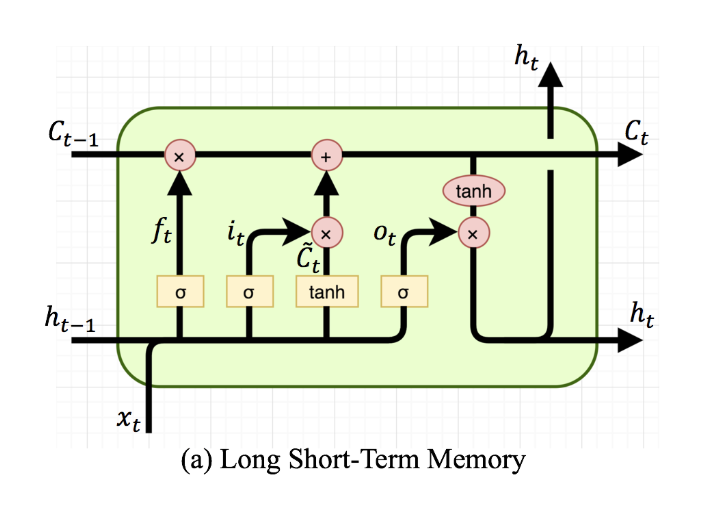

In [75]:
in_features = 100
out_features = 10
num_seq = 2
N = 3

In [76]:
model1 = nn.LSTM(in_features,out_features,num_layers=1)

In [77]:
for param in model1.parameters():
    print(param.shape)

torch.Size([40, 100])
torch.Size([40, 10])
torch.Size([40])
torch.Size([40])


In [78]:
class MyLSTM(nn.Module):
    def __init__(self,in_features,out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.Wx = torch.zeros(4 * out_features, in_features)
        self.Wh = torch.zeros(4 * out_features, out_features) 
        self.bx = torch.zeros(4 * out_features)
        self.bh = torch.zeros(4 * out_features)
        
    def forward(self, x, h=None, c=None):
        if h is None or c is None:
            _, N, _ = x.shape
            h = torch.zeros(N, self.out_features)
            c = torch.zeros(N, self.out_features)
        Wii = self.Wx[0:self.out_features,:]
        Wif = self.Wx[self.out_features:2*self.out_features,:]
        Wig = self.Wx[2*self.out_features:3*self.out_features,:]
        Wio = self.Wx[3*self.out_features:,:]
        
        bii = self.bx[0:self.out_features]
        bif = self.bx[self.out_features:2*self.out_features]
        big = self.bx[2*self.out_features:3*self.out_features]
        bio = self.bx[3*self.out_features:]
        
        Whi = self.Wh[0:self.out_features,:]
        Whf = self.Wh[self.out_features:2*self.out_features,:]
        Whg = self.Wh[2*self.out_features:3*self.out_features,:]
        Who = self.Wh[3*self.out_features:,:]
        
        bhi = self.bh[0:self.out_features]
        bhf = self.bh[self.out_features:2*self.out_features]
        bhg = self.bh[2*self.out_features:3*self.out_features]
        bho = self.bh[3*self.out_features:]
        
        o = []
        for x_ in x:
            it = torch.sigmoid(x_ @ Wii.T + bii + h @ Whi.T + bhi)
            ft = torch.sigmoid(x_ @ Wif.T + bif +  h @ Whf.T + bhf)
            gt = torch.tanh(x_ @ Wig.T + big + h @ Whg.T + bhg)
            ot = torch.sigmoid(x_ @ Wio.T + bio +  h @ Who.T + bho)
            c = ft * c + it * gt
            h = ot * torch.tanh(c)
            o.append(h)
        
        return o, (h, c)

In [79]:
model2 = MyLSTM(100,10)

In [80]:
params = [param for param in model1.parameters()]

In [81]:
model2.Wx.data = params[0].data
model2.Wh.data = params[1].data
model2.bx.data = params[2].data
model2.bh.data = params[3].data

In [82]:
dummy_x = torch.zeros(num_seq,N,in_features)

In [83]:
o1, (h1,c1) = model1(dummy_x)
o2, (h2,c2) = model2(dummy_x)

In [84]:
o1,o2

(tensor([[[-0.1096, -0.0011, -0.0289,  0.0106, -0.0236,  0.0608, -0.0437,
            0.0367,  0.1228,  0.0014],
          [-0.1096, -0.0011, -0.0289,  0.0106, -0.0236,  0.0608, -0.0437,
            0.0367,  0.1228,  0.0014],
          [-0.1096, -0.0011, -0.0289,  0.0106, -0.0236,  0.0608, -0.0437,
            0.0367,  0.1228,  0.0014]],
 
         [[-0.1622,  0.0077, -0.0465,  0.0086, -0.0232,  0.0862, -0.0526,
            0.0585,  0.1784,  0.0073],
          [-0.1622,  0.0077, -0.0465,  0.0086, -0.0232,  0.0862, -0.0526,
            0.0585,  0.1784,  0.0073],
          [-0.1622,  0.0077, -0.0465,  0.0086, -0.0232,  0.0862, -0.0526,
            0.0585,  0.1784,  0.0073]]], grad_fn=<StackBackward0>),
 [tensor([[-0.1096, -0.0011, -0.0289,  0.0106, -0.0236,  0.0608, -0.0437,  0.0367,
            0.1228,  0.0014],
          [-0.1096, -0.0011, -0.0289,  0.0106, -0.0236,  0.0608, -0.0437,  0.0367,
            0.1228,  0.0014],
          [-0.1096, -0.0011, -0.0289,  0.0106, -0.0236,  0.0608,

Usando LSTM (Long-Short term memory) para speech recognition

In [85]:
train_ds = MySpectrogramDataset(sc_train_ds)
test_ds = MySpectrogramDataset(sc_test_ds)

In [86]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128,shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=128,shuffle=True)

In [87]:
for x,y in train_dl:
  print(x.shape)
  print(y)
  break

torch.Size([128, 1, 81, 101])
tensor([18, 10, 11,  7, 34, 11, 31, 11, 24,  4, 31, 10,  7, 28, 25, 30,  4,  1,
        27, 11, 22, 22, 17,  4,  6, 33,  6,  7, 27, 20, 13, 22, 21,  5, 29, 19,
         1, 26,  4,  5,  5, 25, 29,  3, 21,  0, 22, 23, 30, 29, 30,  8, 17, 23,
        24, 19, 17, 30, 19, 26, 24,  0, 33, 32,  8,  7, 28, 12,  2, 20, 10, 12,
        28, 34, 29, 22, 30, 33, 15, 32,  1,  1,  9, 26, 34, 18, 27, 18, 30, 10,
        25, 19, 25,  2, 11,  5, 33,  4,  1,  5, 32, 10, 29, 21,  7, 20,  6, 26,
         3, 22, 33, 24, 18, 30, 11, 13,  3, 25, 22, 26,  9, 23,  0, 25, 28,  7,
        14, 31])


In [89]:
class MyRNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.lstm = nn.LSTM(81,16,2,batch_first=True)
    self.flatten = nn.Flatten()
    self.classifier = nn.Linear(16*101,35)
  def forward(self, x):
    x = x.reshape((-1,81,101)).transpose(2,1)
    o, (h,c) = self.lstm(x)
    return self.classifier(self.flatten(o))

In [90]:
model = MyRNN().to(dev)

In [ ]:
crit = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(),lr=0.1)
train(model,train_dl, test_dl, crit,optim,epochs=10)

epoch: 0, train loss: 2.362145735037992, train acc: 33.34040521905166%, test loss: 1.6752478674400684, test acc: 52.20354384370741%
epoch: 1, train loss: 1.4466815357901393, train acc: 58.39963226194265%, test loss: 1.4582744573437891, test acc: 58.48250795093139%
epoch: 2, train loss: 1.1636796311150848, train acc: 66.35903963791945%, test loss: 1.2468212104813998, test acc: 64.46160835983643%
epoch: 3, train loss: 1.0210319036564497, train acc: 70.26389920205555%, test loss: 1.069501391243796, test acc: 68.39618355293048%
epoch: 4, train loss: 0.9288889073835599, train acc: 72.80270617493488%, test loss: 1.0236324436616067, test acc: 70.24988641526579%
epoch: 5, train loss: 0.8788157914333933, train acc: 74.29133811864267%, test loss: 0.9737023355136084, test acc: 71.39482053611995%
epoch: 6, train loss: 0.8456303366371409, train acc: 75.16118006199686%, test loss: 0.8687089470236801, test acc: 74.31167651067696%
epoch: 7, train loss: 0.7986788315302377, train acc: 76.28325259597138%

In [ ]:
torch.save(model.state_dict(),"speech_commands_lstm.ckpt")

In [91]:
model.load_state_dict(torch.load("speech_commands_lstm.ckpt"))

<All keys matched successfully>

In [95]:
idx = 400
audio_ = Audio(data=sc_test_ds[idx][0][0].numpy(),rate=16000)
pred = torch.argmax(model(test_ds[idx][0].reshape(1,1,81,101).to(dev)).cpu(),axis=1)[0].item()
print(speech_labels[pred])
display(audio_)

Eight
